# 📘 Control Dataset Metrics Comparison
This script compares peak-, cell-, and event-level metrics across 6 control image sequences
to assess statistical consistency and visualize distributions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from itertools import combinations

sns.set(style="whitegrid")

# 📂 Define Control Datasets

In [3]:
control_paths = {
    "20250404 - IS1": "D:/Mateo/20250404/Output/IS3",
    "20250404 - IS2": "D:/Mateo/20250404/Output/IS3",
    "20250404 - IS3": "D:/Mateo/20250404/Output/IS3",
    "20250404 - IS4": "D:/Mateo/20250404/Output/IS3",
    "20250404 - IS5": "D:/Mateo/20250404/Output/IS3",
    "20250404 - IS6": "D:/Mateo/20250404/Output/IS3",
}

# 🔁 Load and Concatenate Data

In [4]:
def load_and_merge(file_name: str) -> pd.DataFrame:
    dfs = []
    for label, path in control_paths.items():
        df = pd.read_csv(f"{path}/{file_name}")
        df["dataset"] = label
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

peaks = load_and_merge("peaks.csv")
cells = load_and_merge("cells.csv")
events = load_and_merge("events.csv")

# Normalize event type
peaks["in_event"] = peaks["in_event"].fillna("individual").str.lower()

# Ensure columns
if "is_active" not in cells.columns:
    cells["is_active"] = cells["num_peaks"].apply(lambda x: 1 if x > 0 else 0)
if "periodicity_score" not in cells.columns:
    cells["periodicity_score"] = np.nan


# 📊 Utility Function: Plot Subplots by Dataset

In [5]:

def plot_metric_by_dataset(df, column, title, bin_width=None, bin_count=None):
    datasets = df["dataset"].unique()
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    for i, dataset in enumerate(sorted(datasets)):
        subset = df[df["dataset"] == dataset]
        clean = subset[column].dropna()

        if clean.empty:
            axs[i].set_title(f"{dataset} (No Data)")
            axs[i].axis("off")
            continue

        if bin_width is not None:
            bins = int((clean.max() - clean.min()) / bin_width) + 1
        else:
            bins = bin_count

        sns.histplot(clean, bins=bins, kde=False, ax=axs[i])
        axs[i].set_title(dataset)
        axs[i].set_xlabel(column)
        axs[i].set_ylabel("Frequency")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# VISUAL COMPARISON

## 📈 PEAK-LEVEL METRICS BY EVENT TYPE


#🔍 Peak Type: Global — 9420 peaks


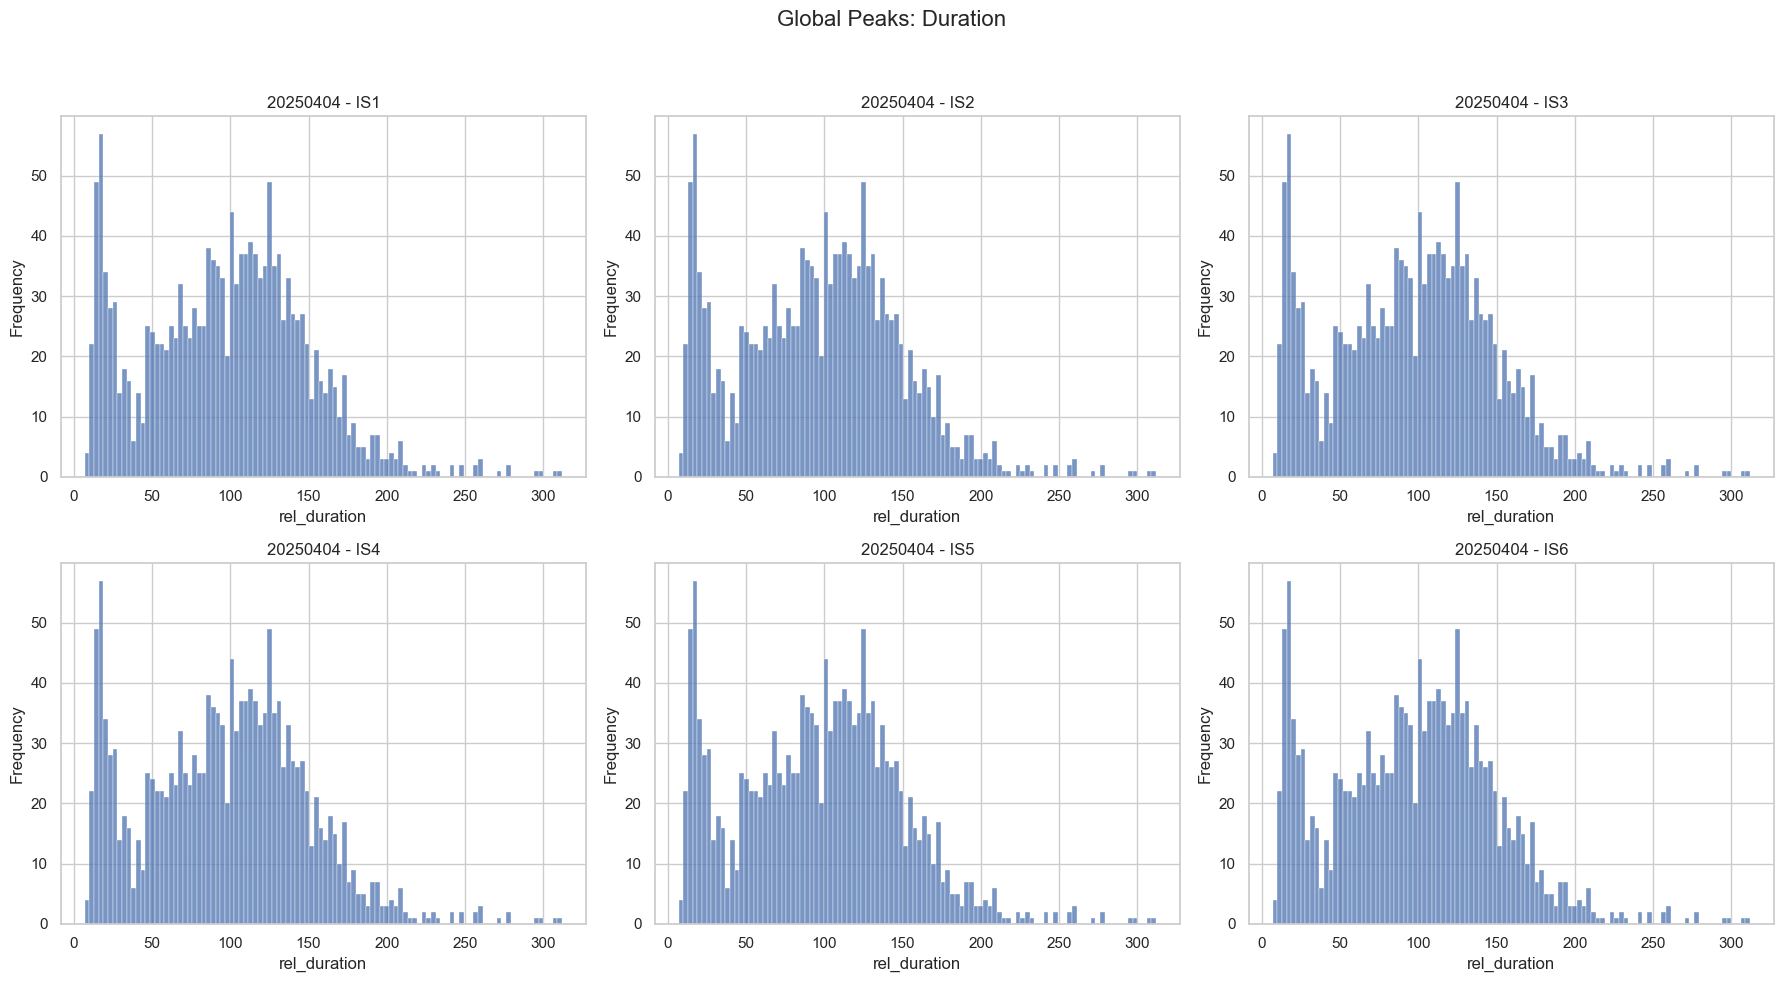

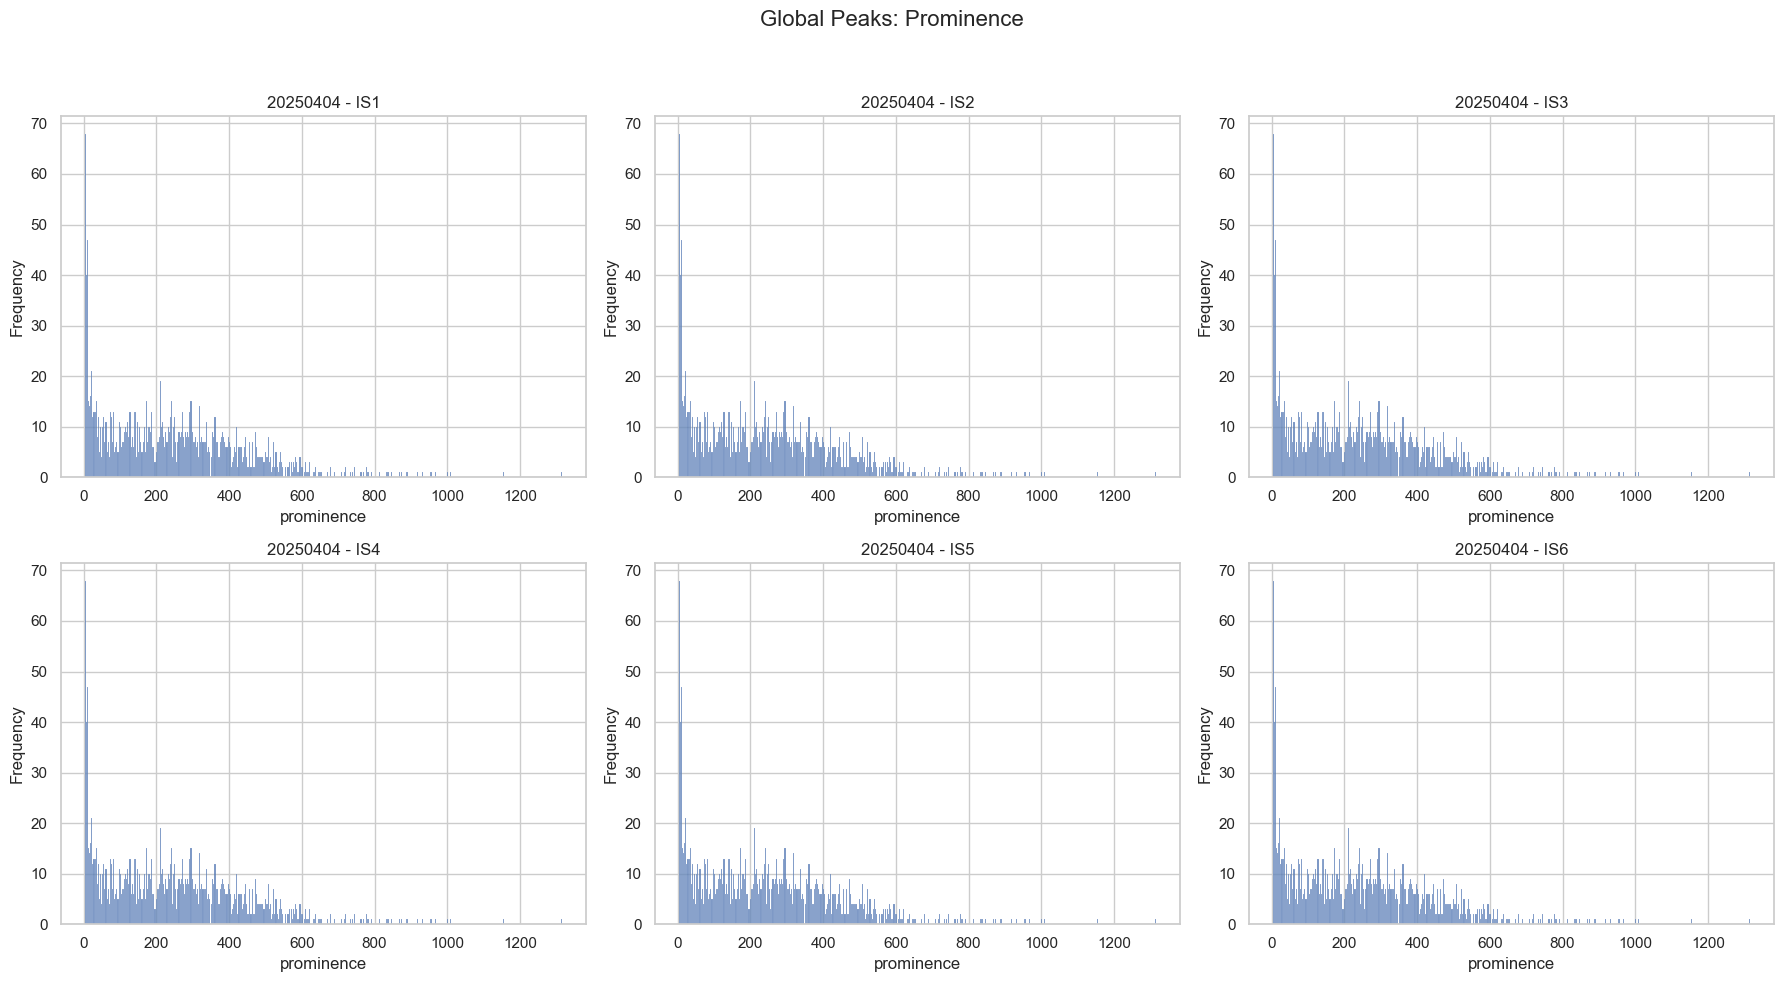

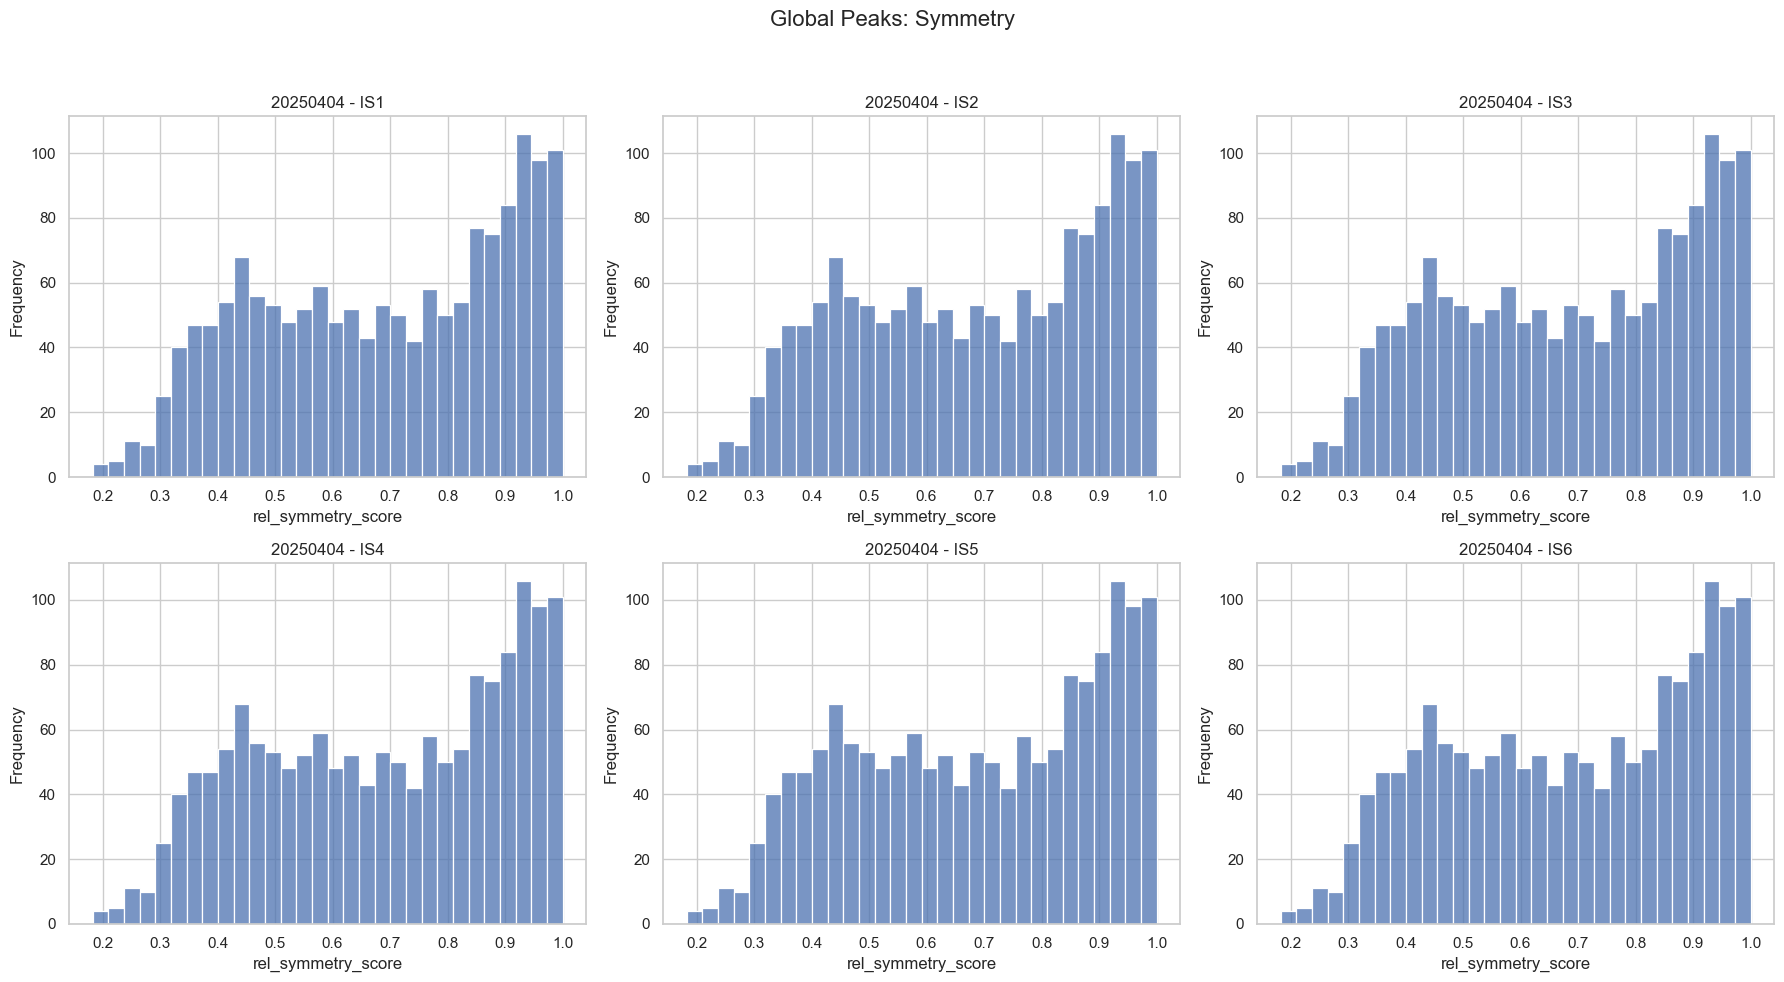


#🔍 Peak Type: Sequential — 17094 peaks


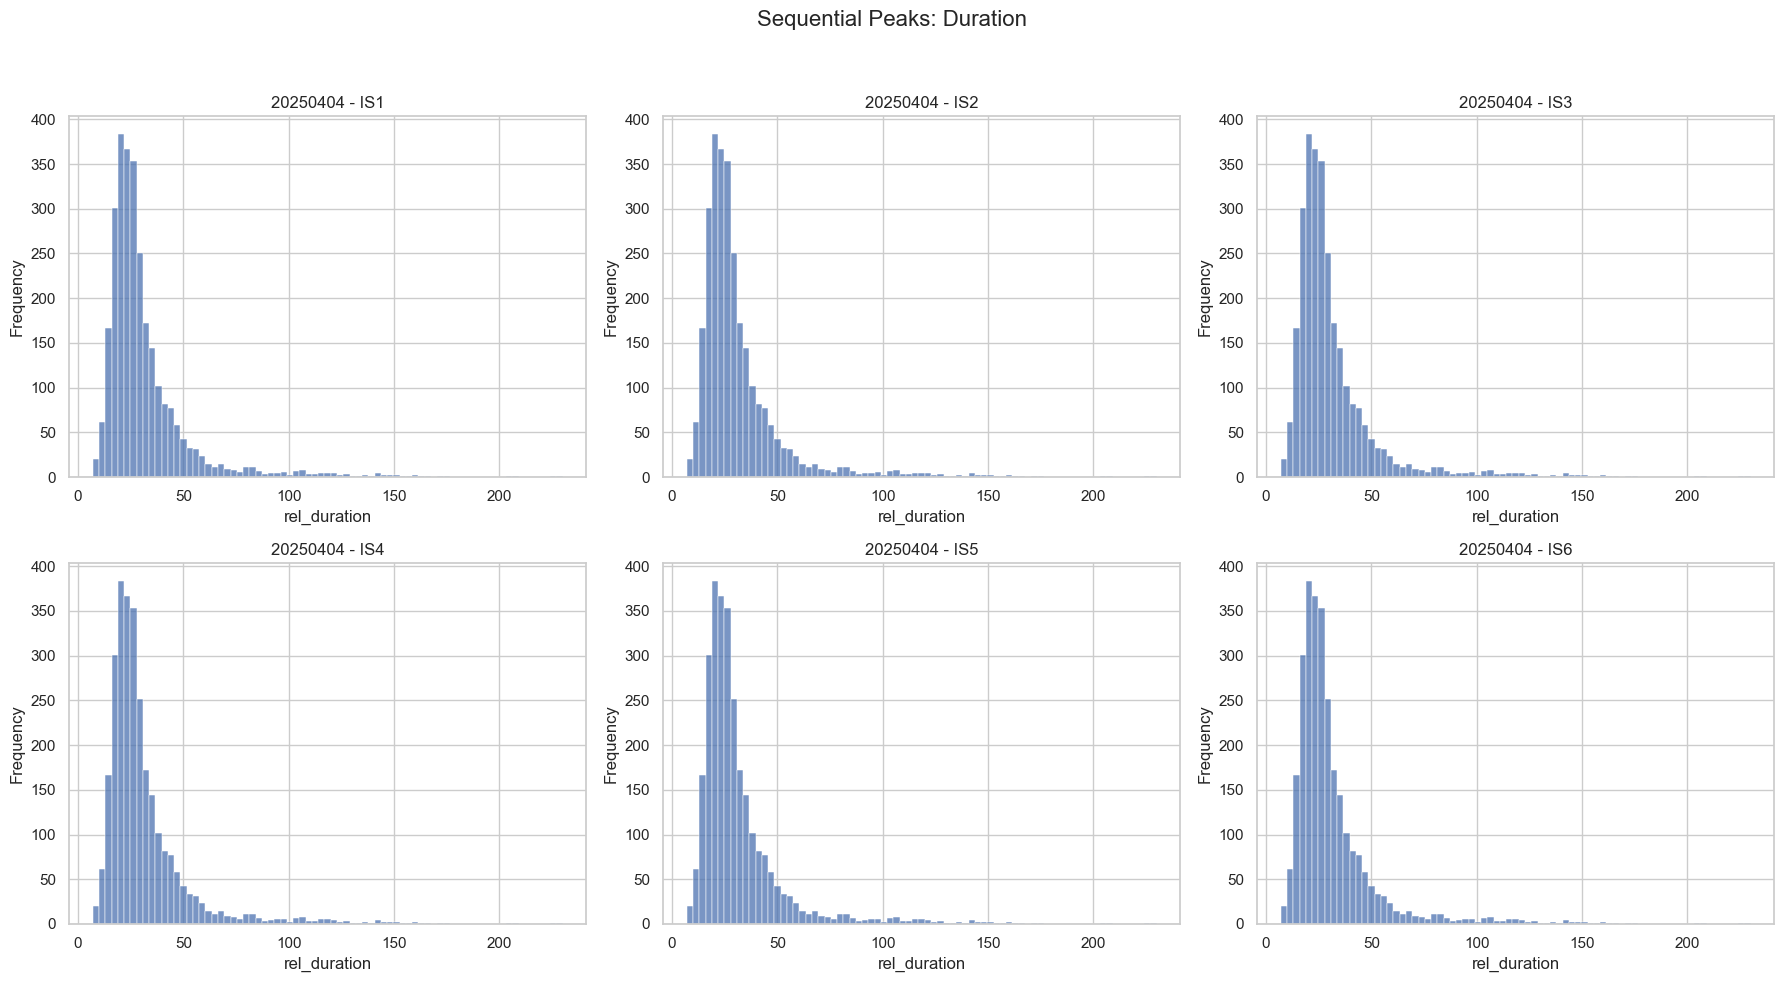

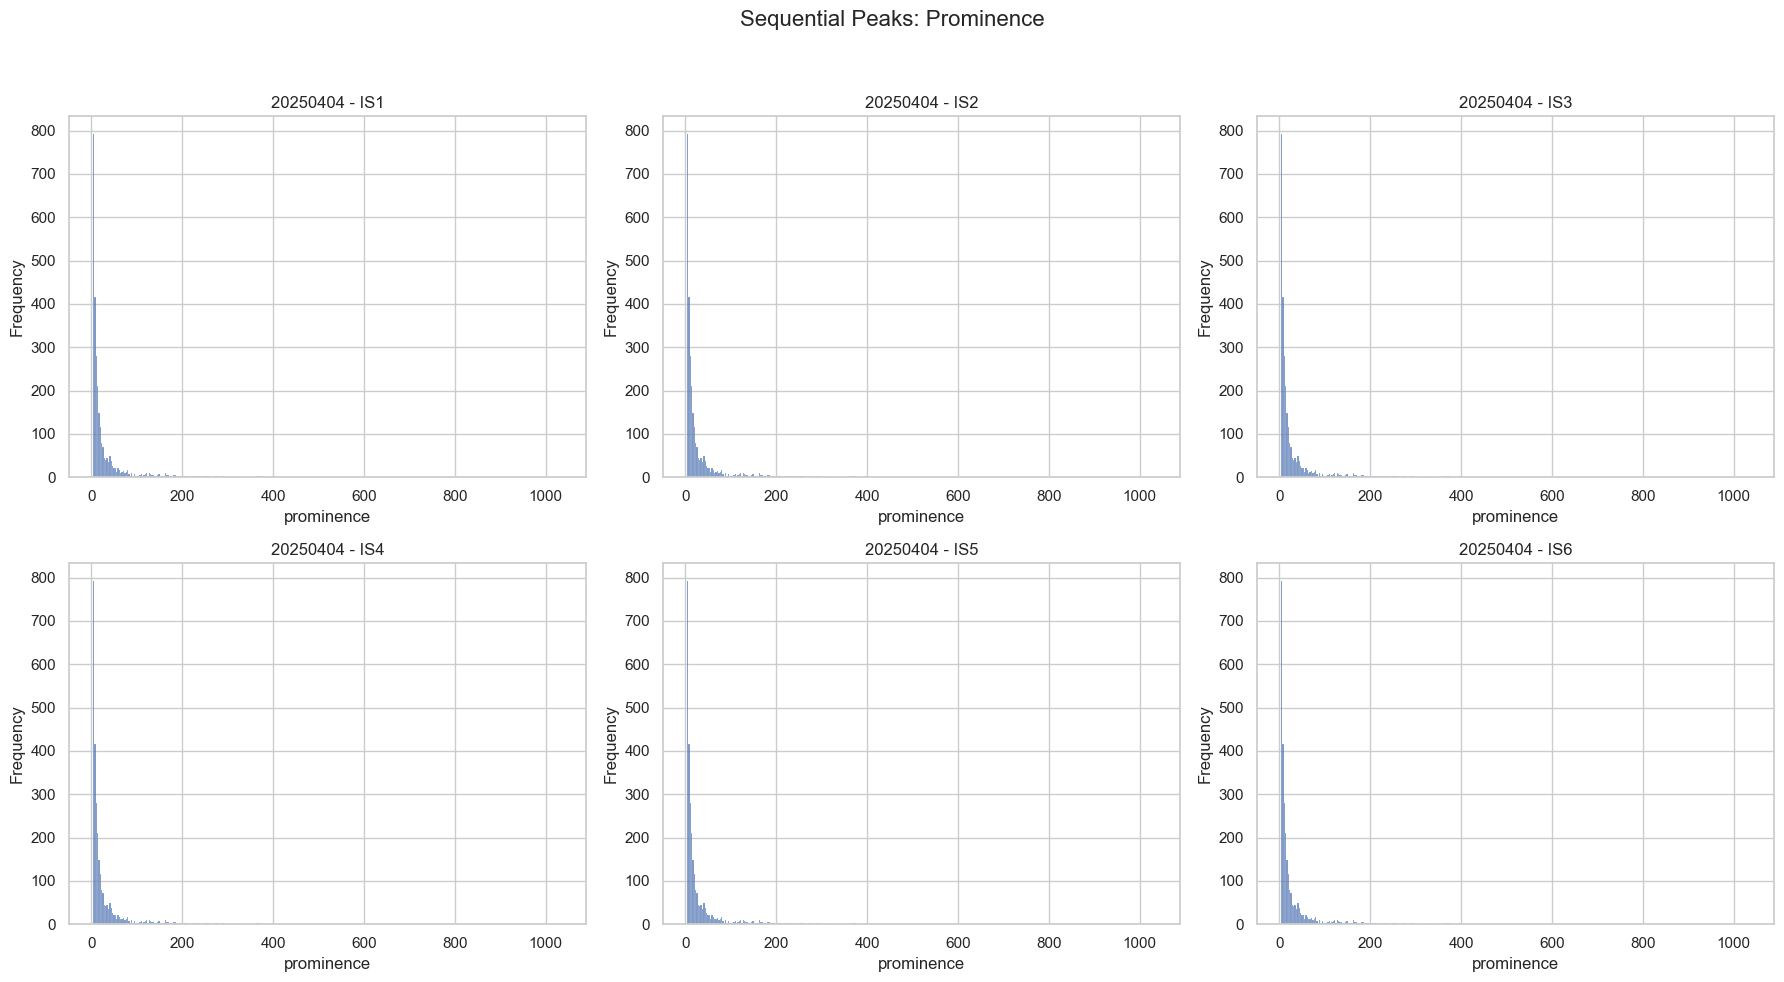

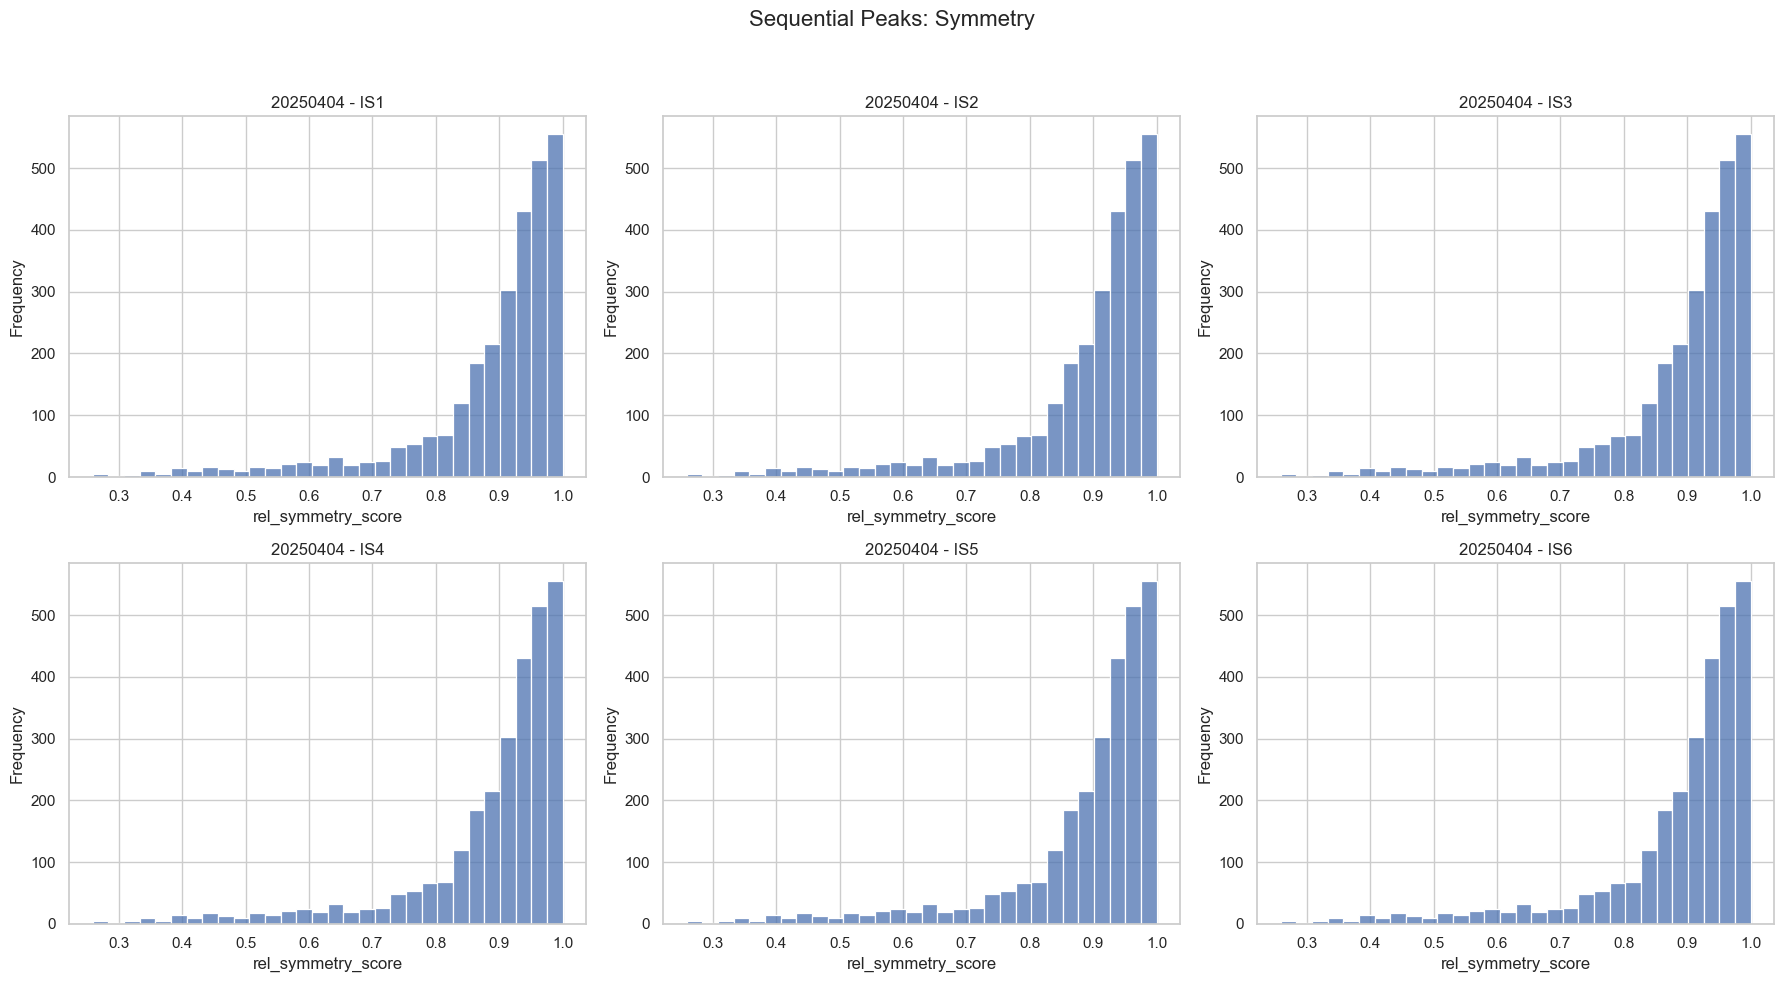


#🔍 Peak Type: Individual — 13872 peaks


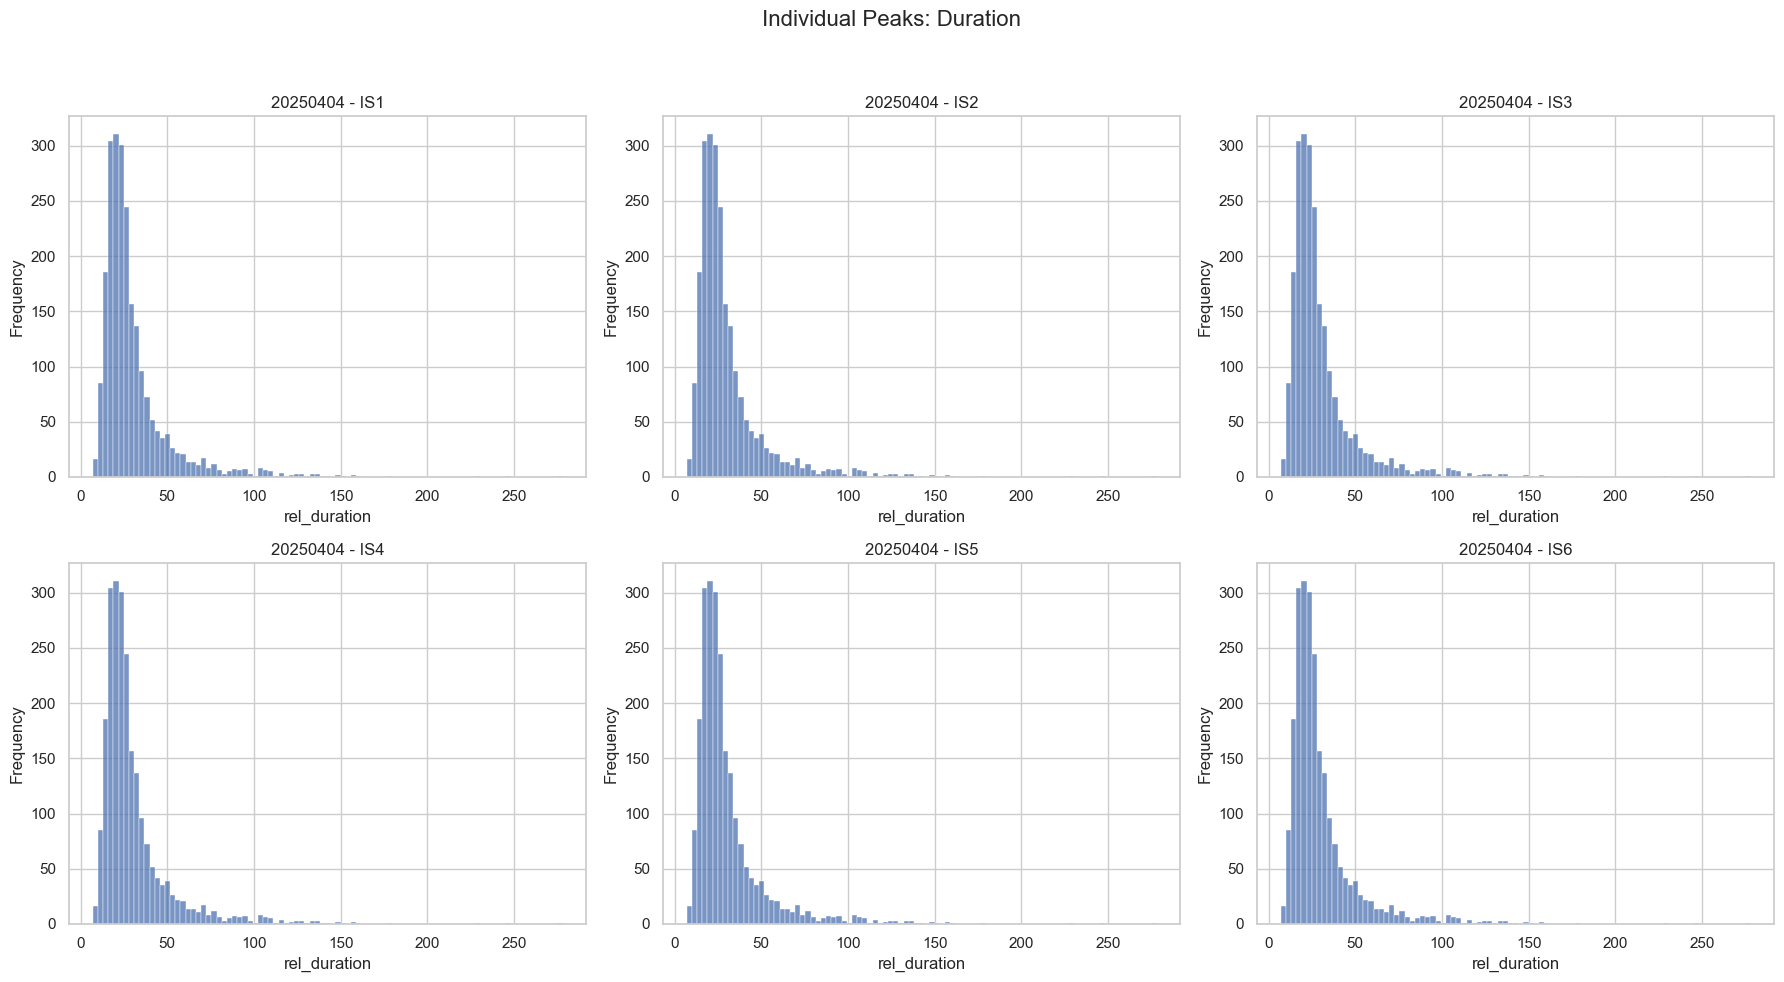

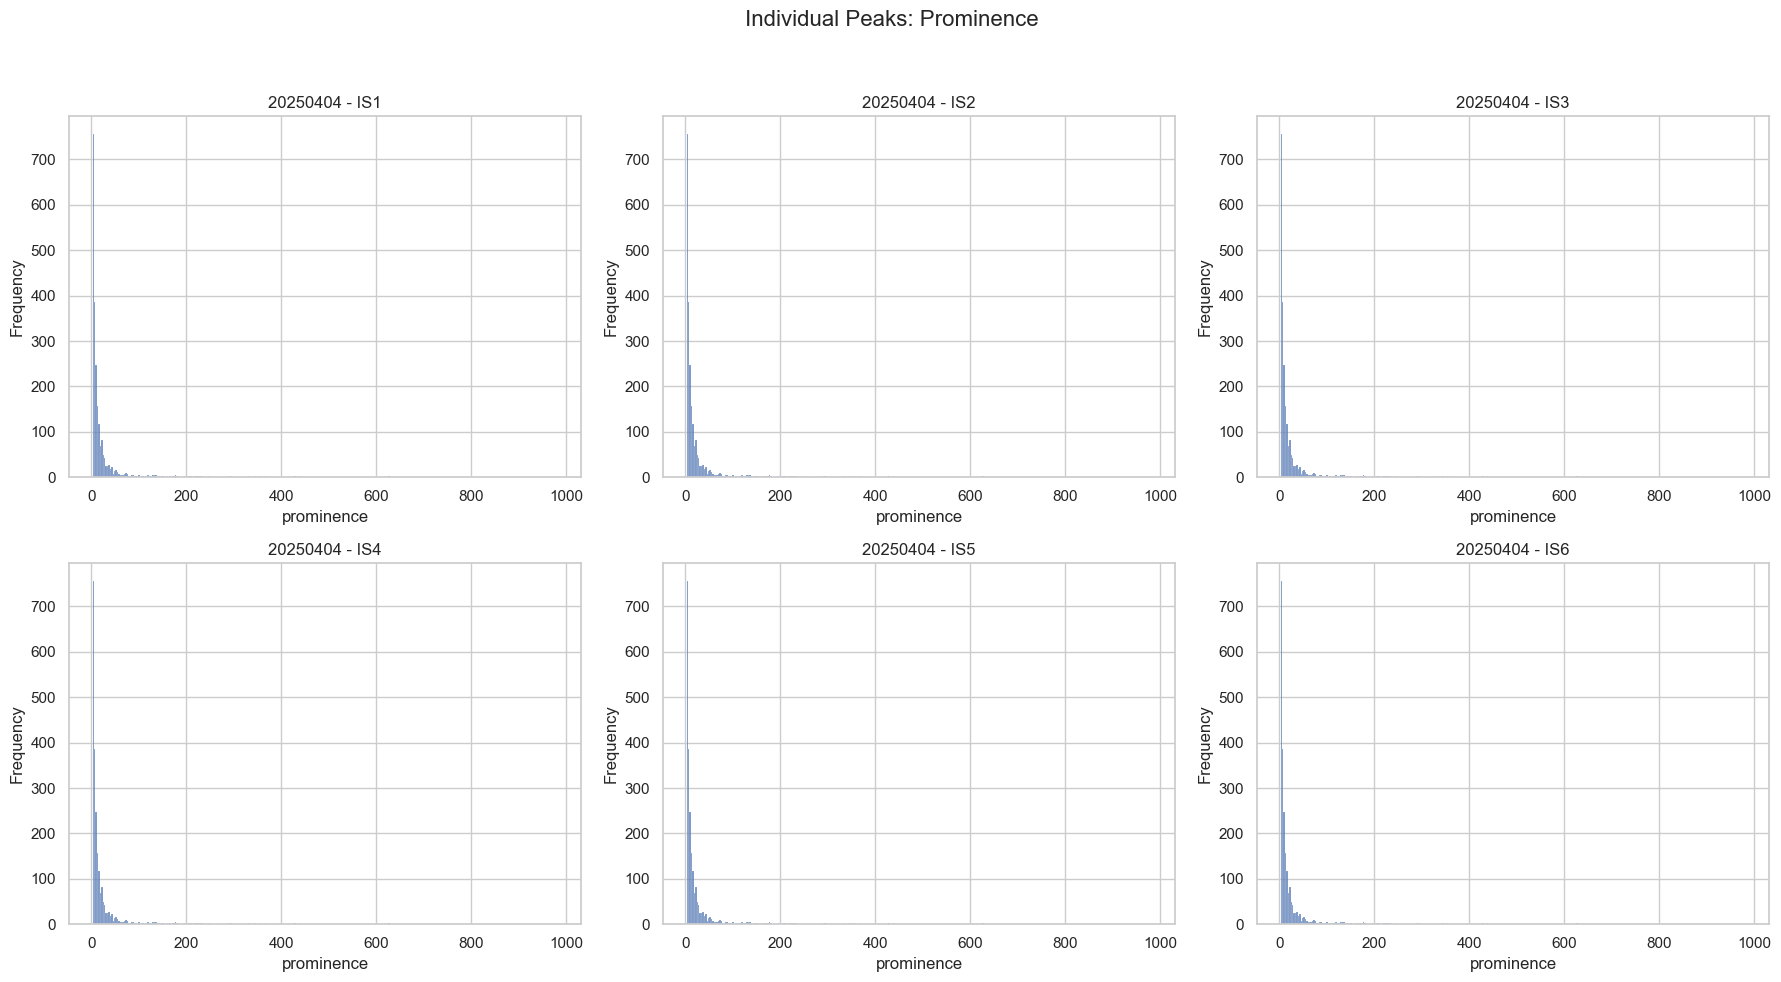

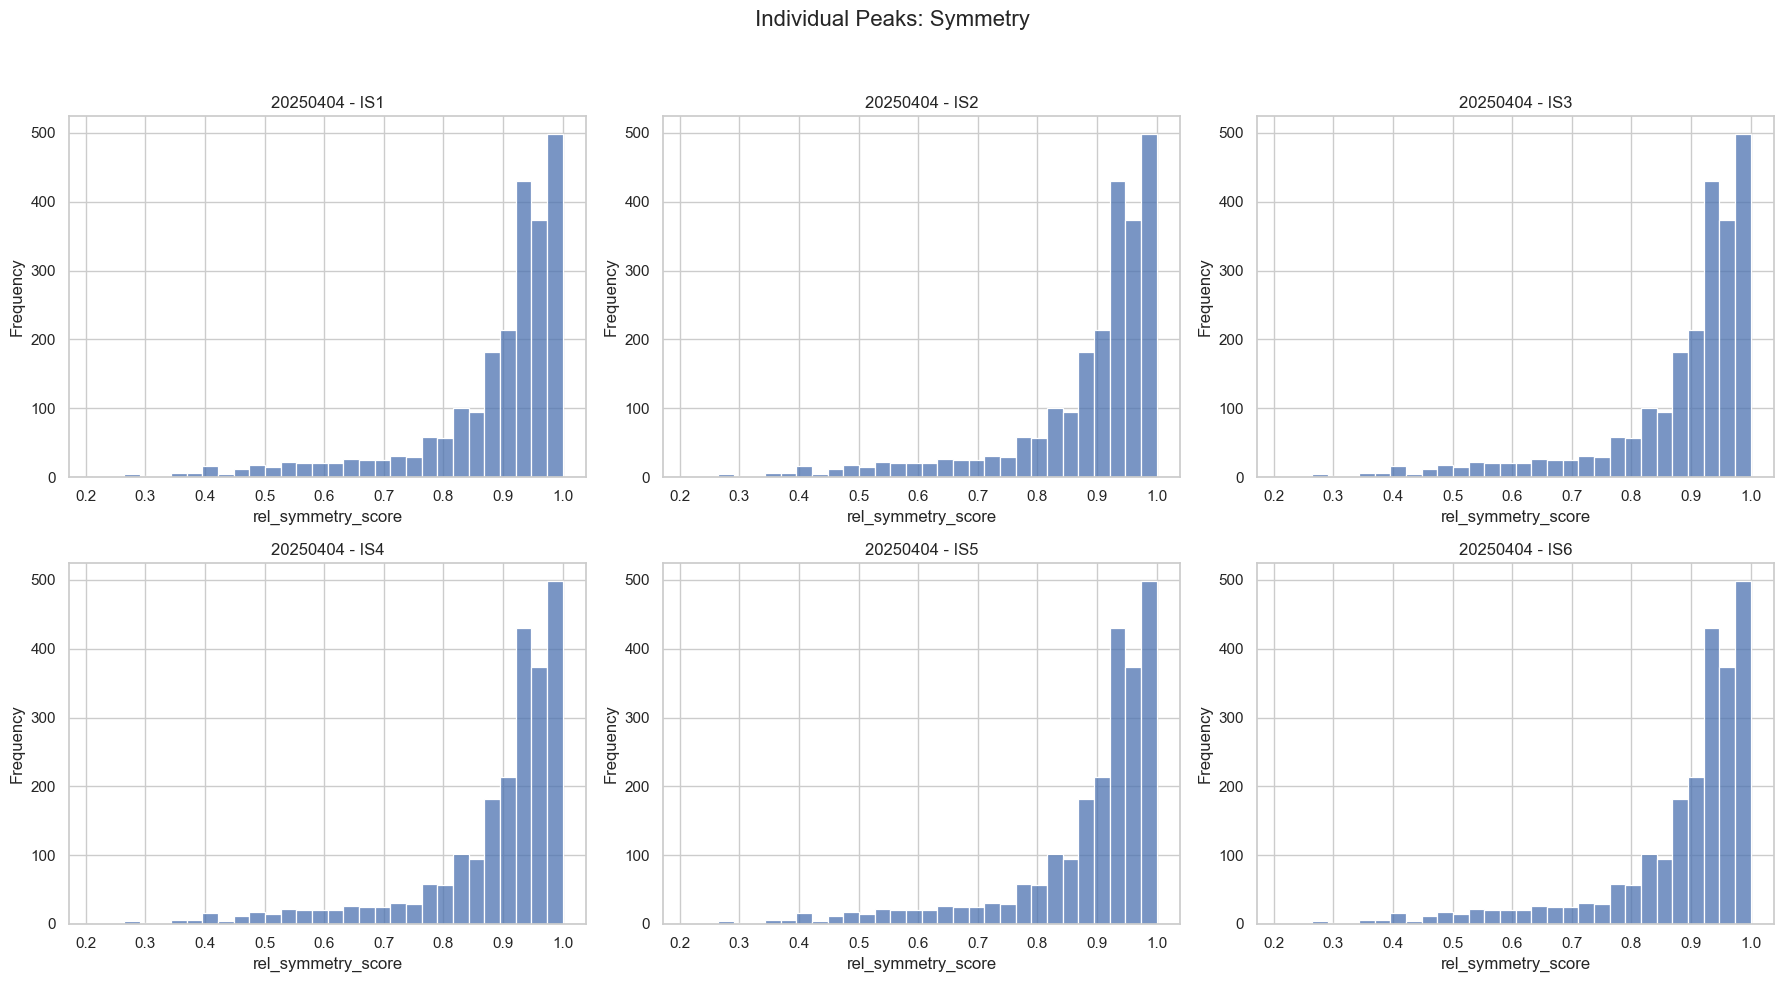

In [6]:

for event_type in ["global", "sequential", "individual"]:
    subset = peaks[peaks["in_event"] == event_type]
    print(f"\n#🔍 Peak Type: {event_type.title()} — {len(subset)} peaks")
    plot_metric_by_dataset(subset, "rel_duration", f"{event_type.title()} Peaks: Duration", bin_width=3)
    plot_metric_by_dataset(subset, "prominence", f"{event_type.title()} Peaks: Prominence", bin_width=3)
    plot_metric_by_dataset(subset, "rel_symmetry_score", f"{event_type.title()} Peaks: Symmetry", bin_count=30)

## 🧬 CELL-LEVEL METRICS

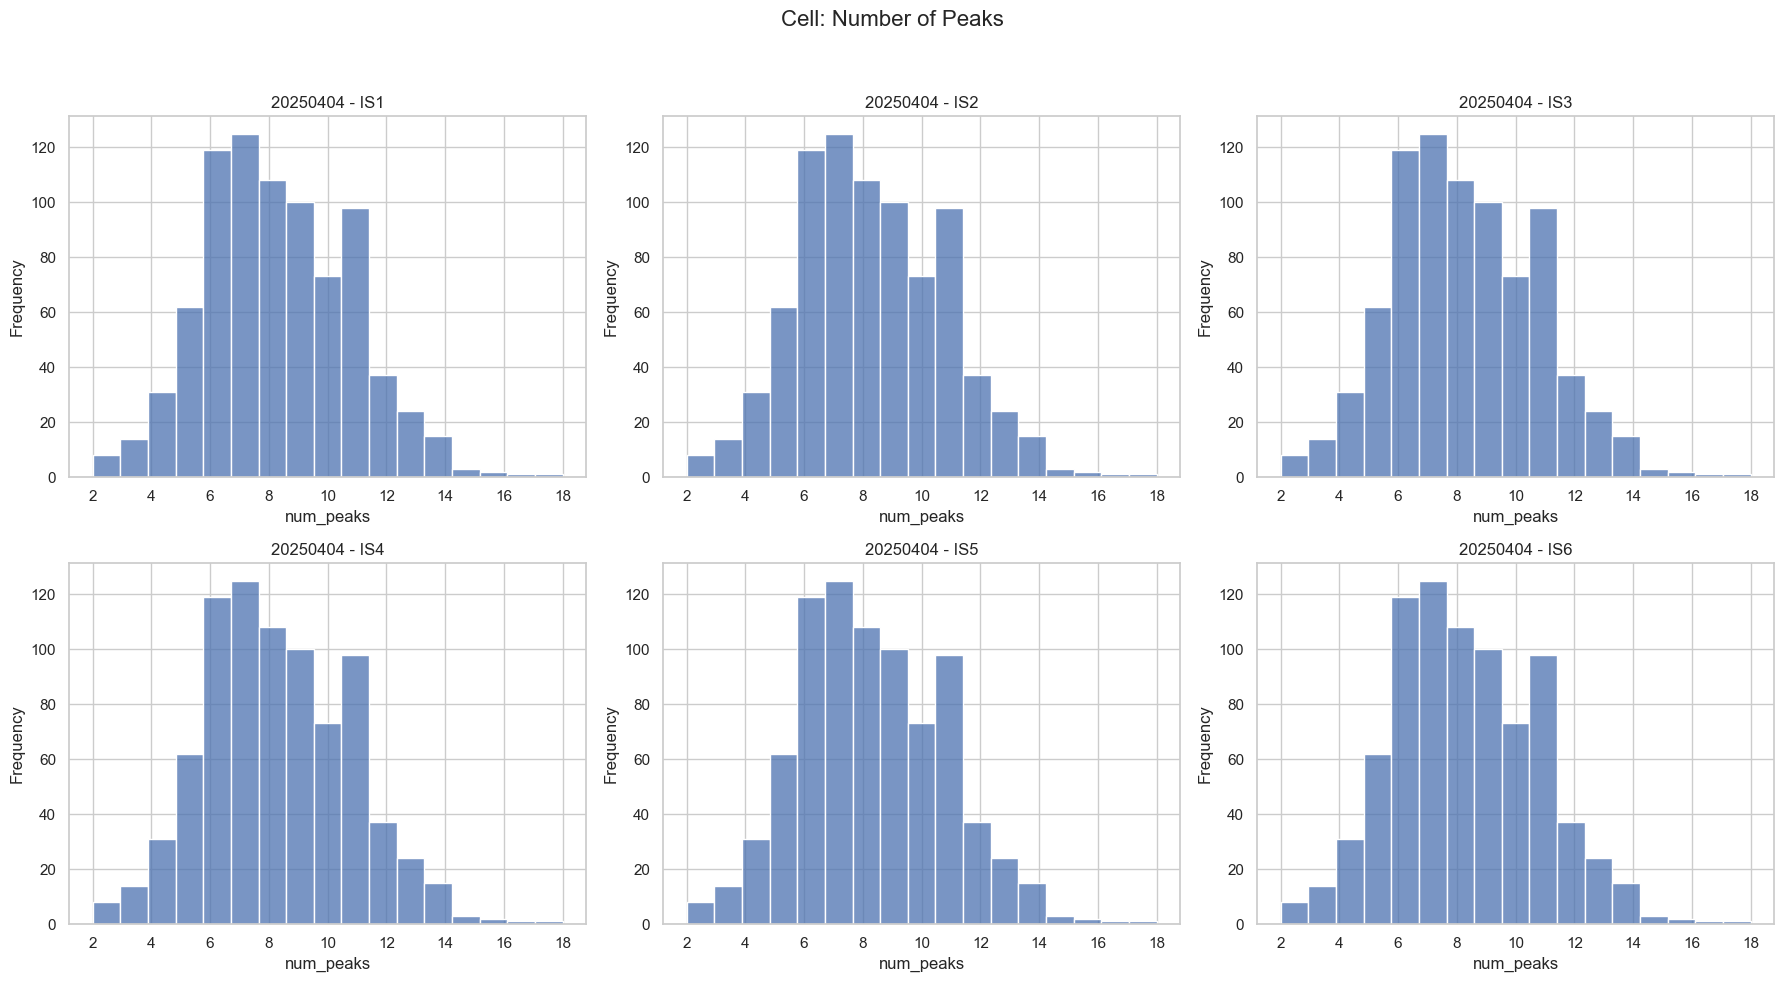

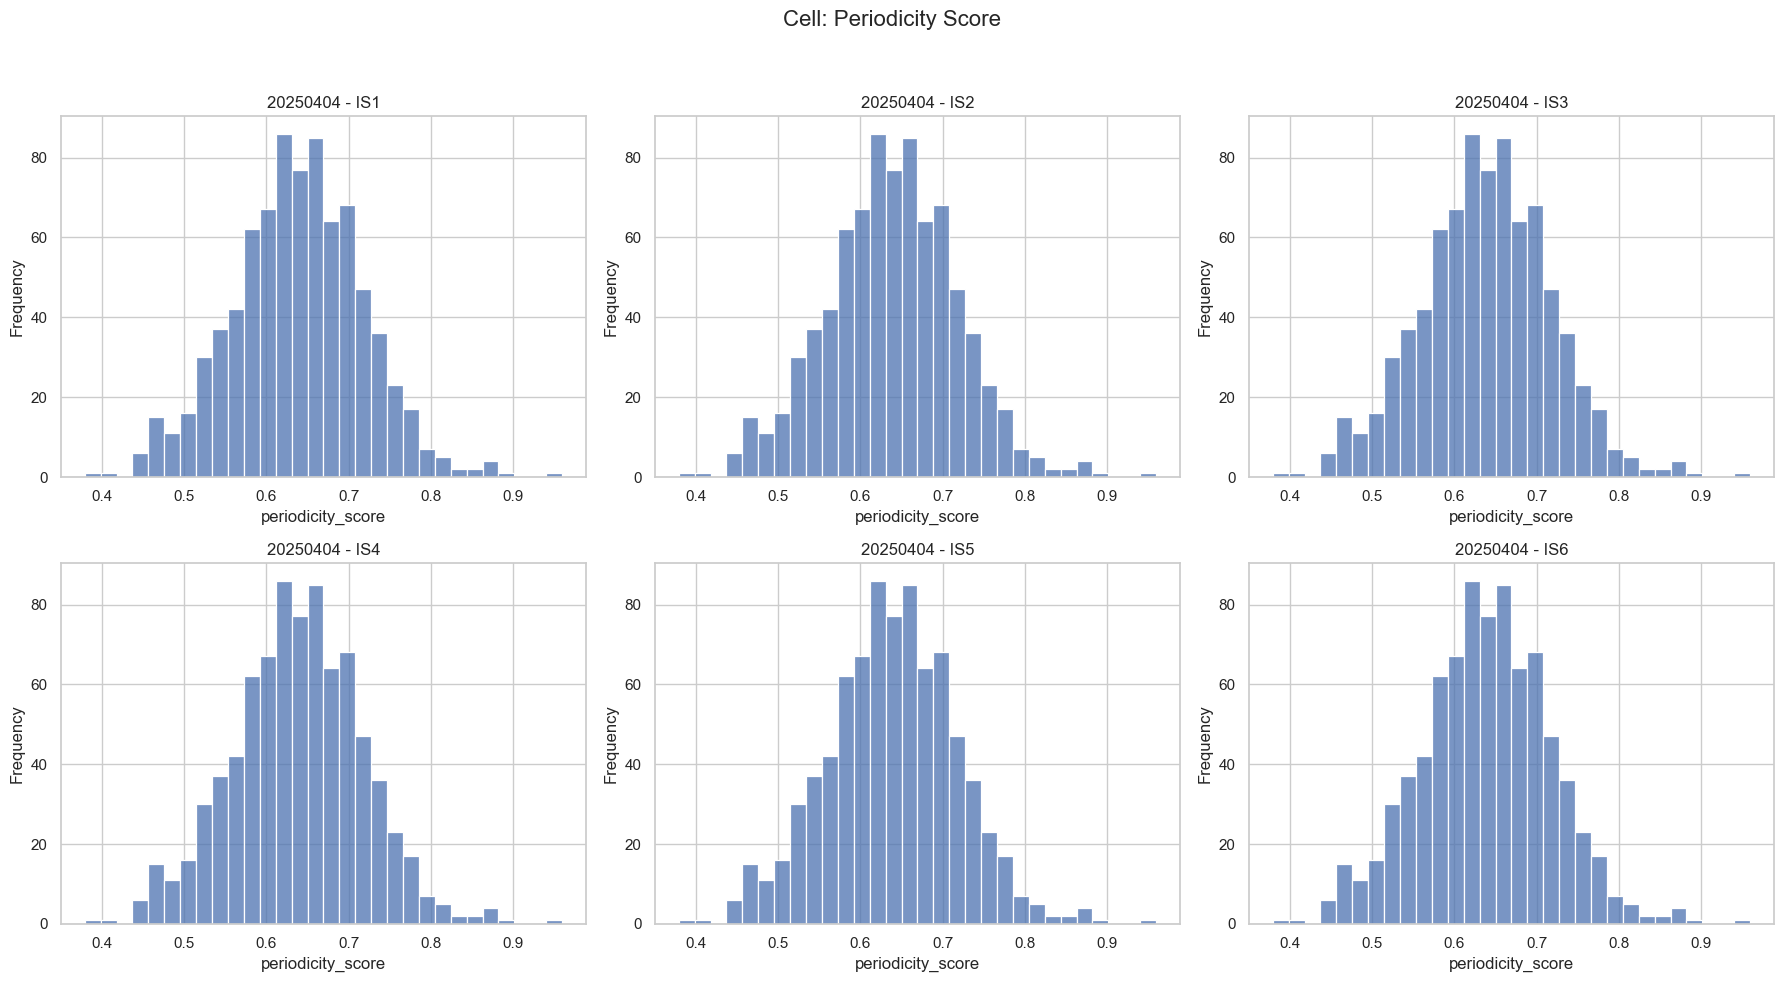

In [ ]:
plot_metric_by_dataset(cells, "num_peaks", "Cell: Number of Peaks", bin_width=1)
plot_metric_by_dataset(cells, "periodicity_score", "Cell: Periodicity Score", bin_width=0.02)

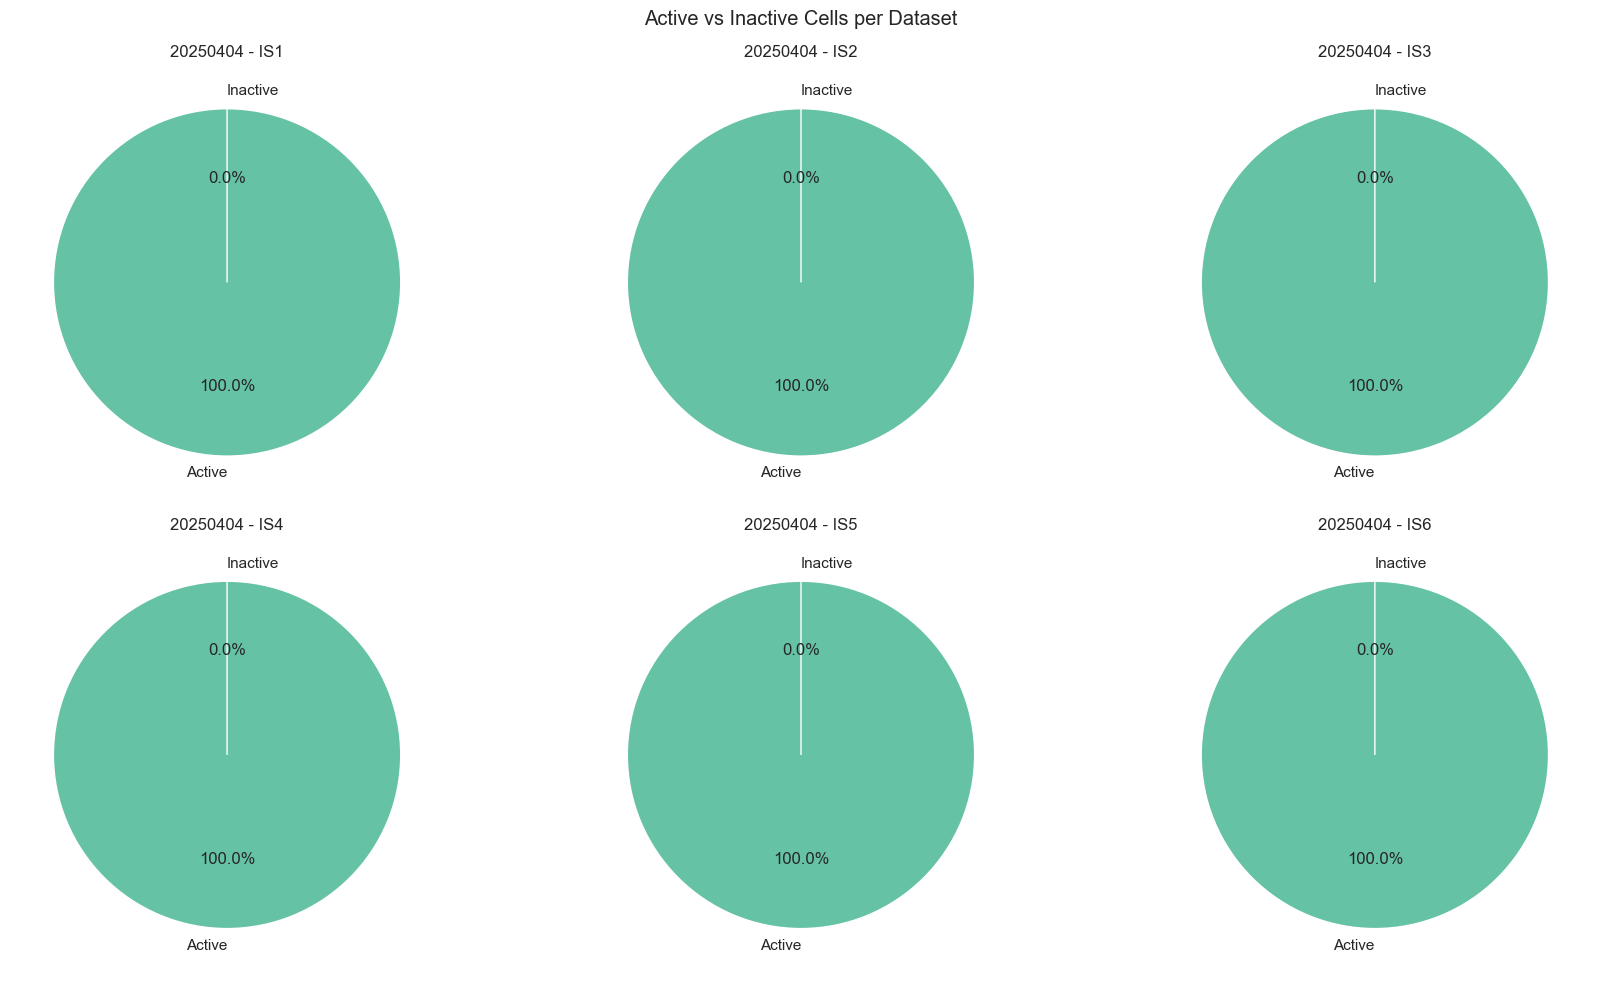

In [8]:

# Active vs Inactive
active_df = cells.copy()
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
for i, dataset in enumerate(sorted(active_df["dataset"].unique())):
    sub = active_df[active_df["dataset"] == dataset]
    status = sub["is_active"].value_counts().reindex([1, 0]).fillna(0)
    status.index = ["Active", "Inactive"]
    axs[i].pie(status, labels=status.index, autopct="%1.1f%%", startangle=90, colors=["#66c2a5", "#d3d3d3"])
    axs[i].set_title(dataset)
plt.suptitle("Active vs Inactive Cells per Dataset")
plt.tight_layout()
plt.show()

## 🌊 EVENT-LEVEL METRICS (Sequential Events Only)

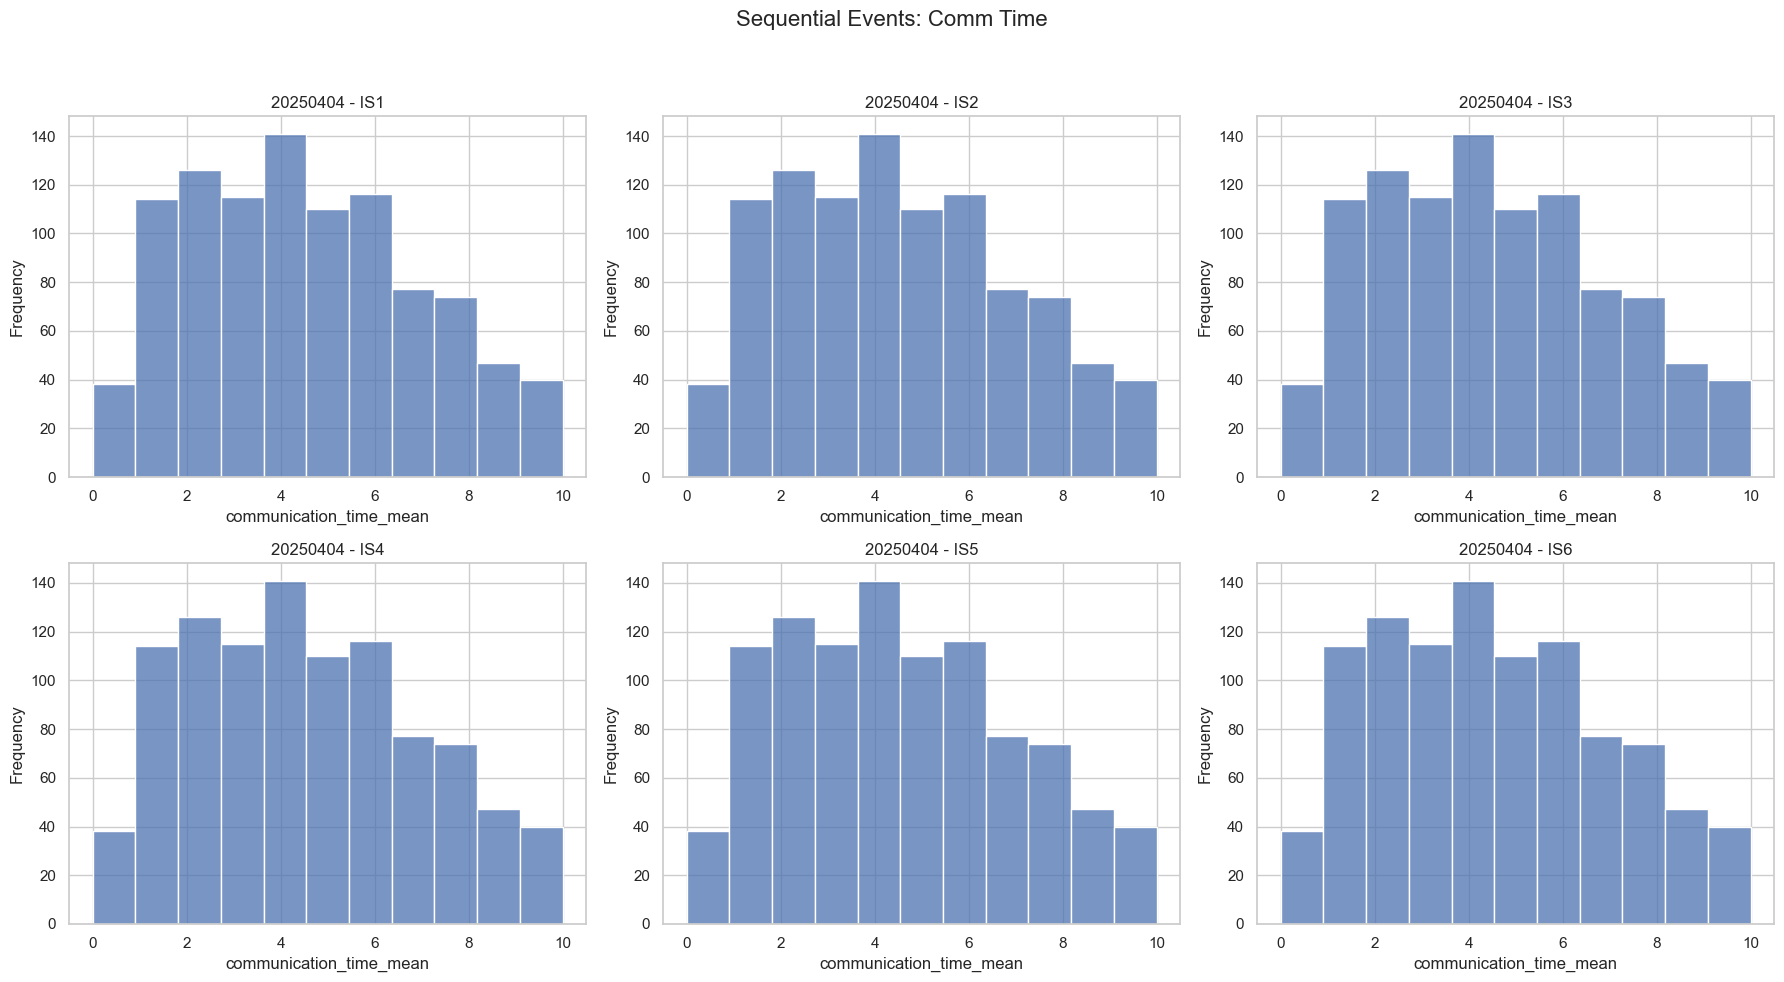

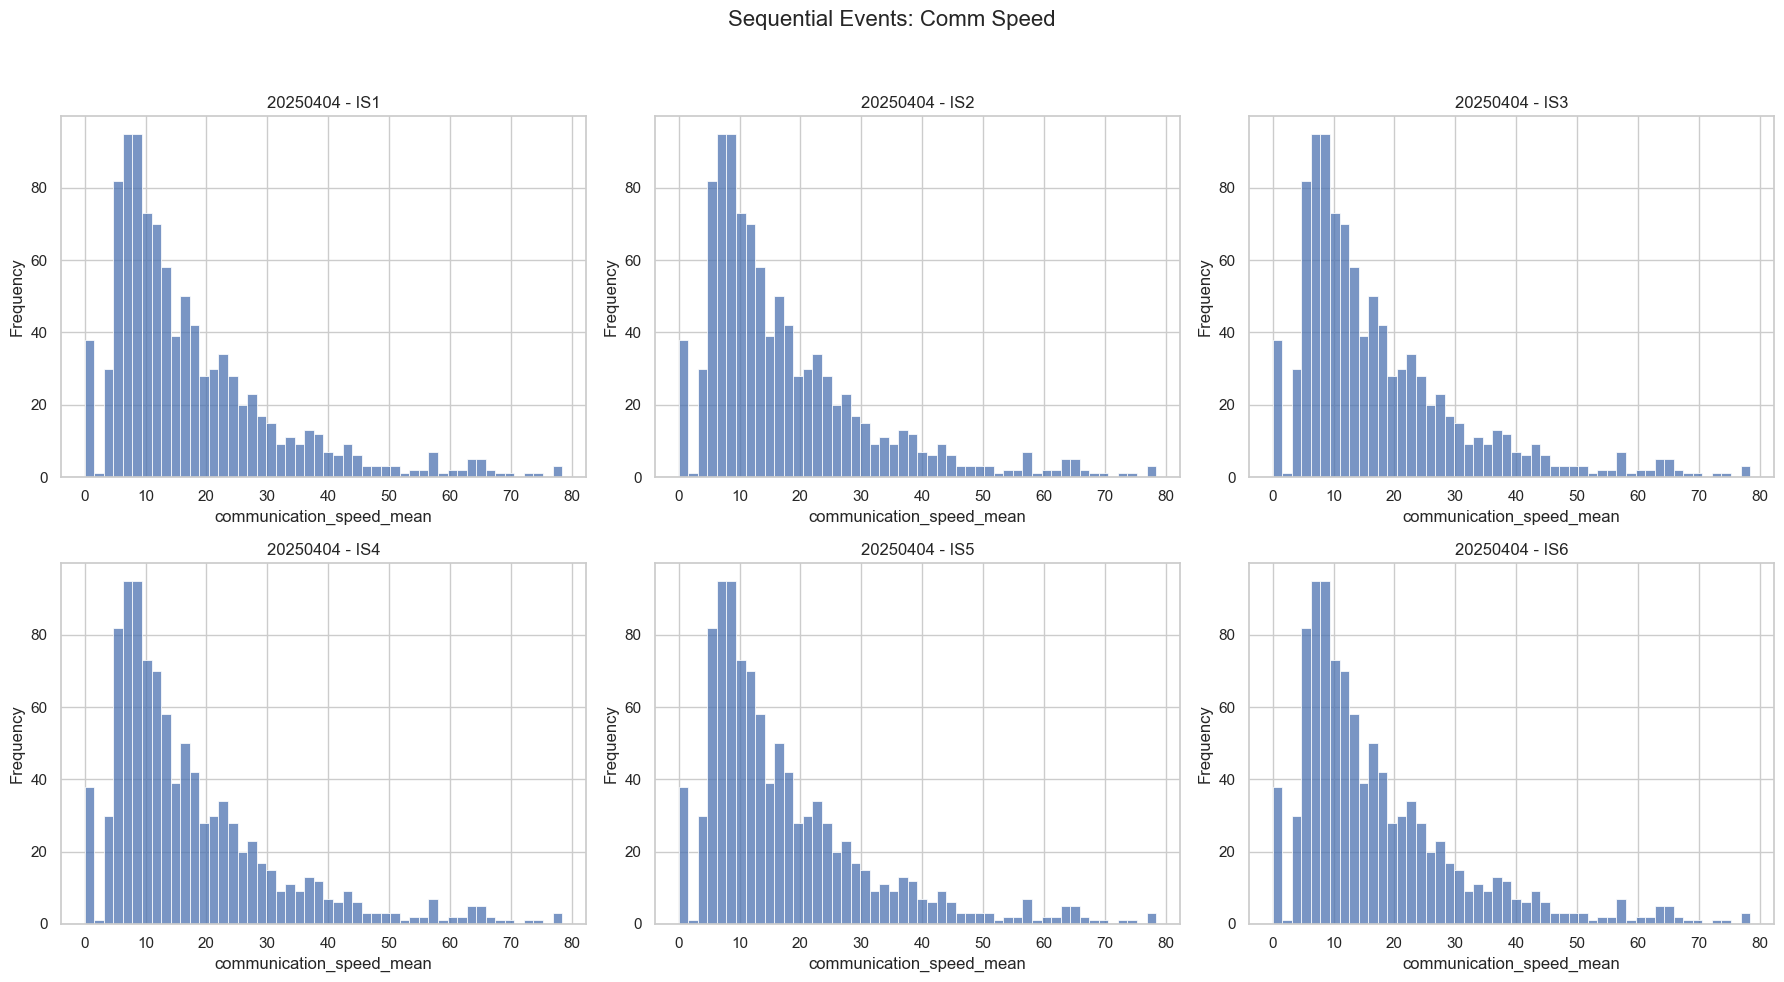

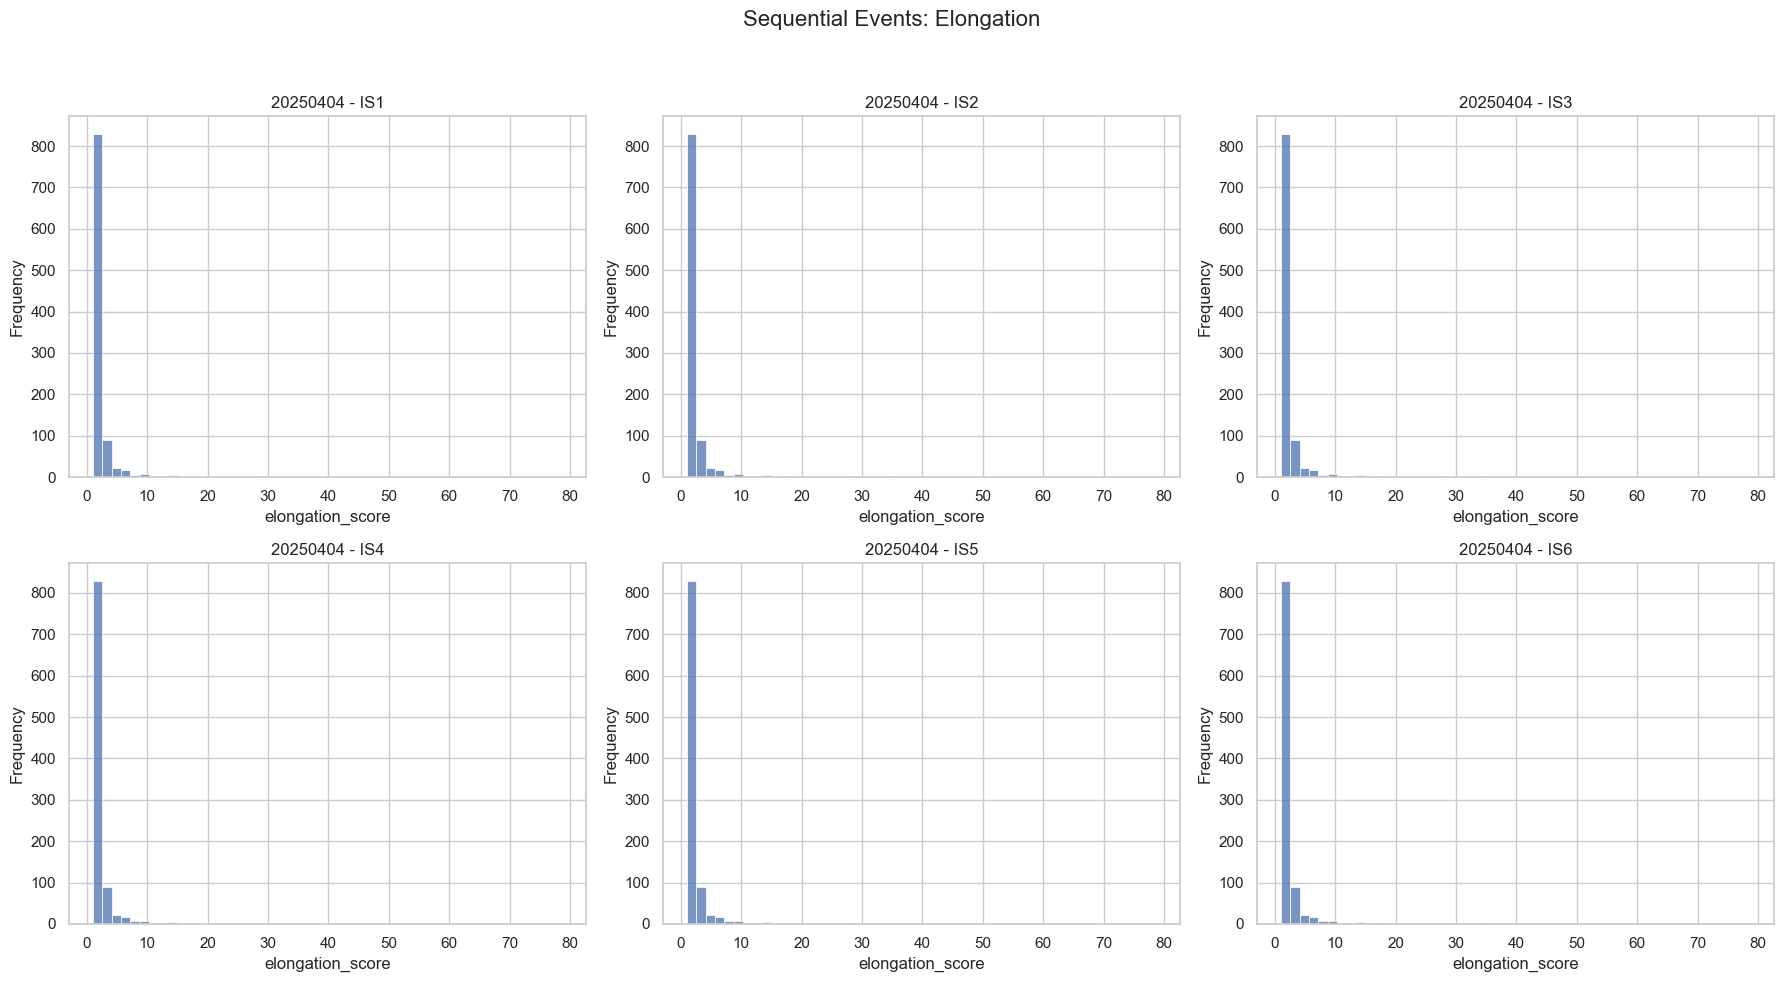

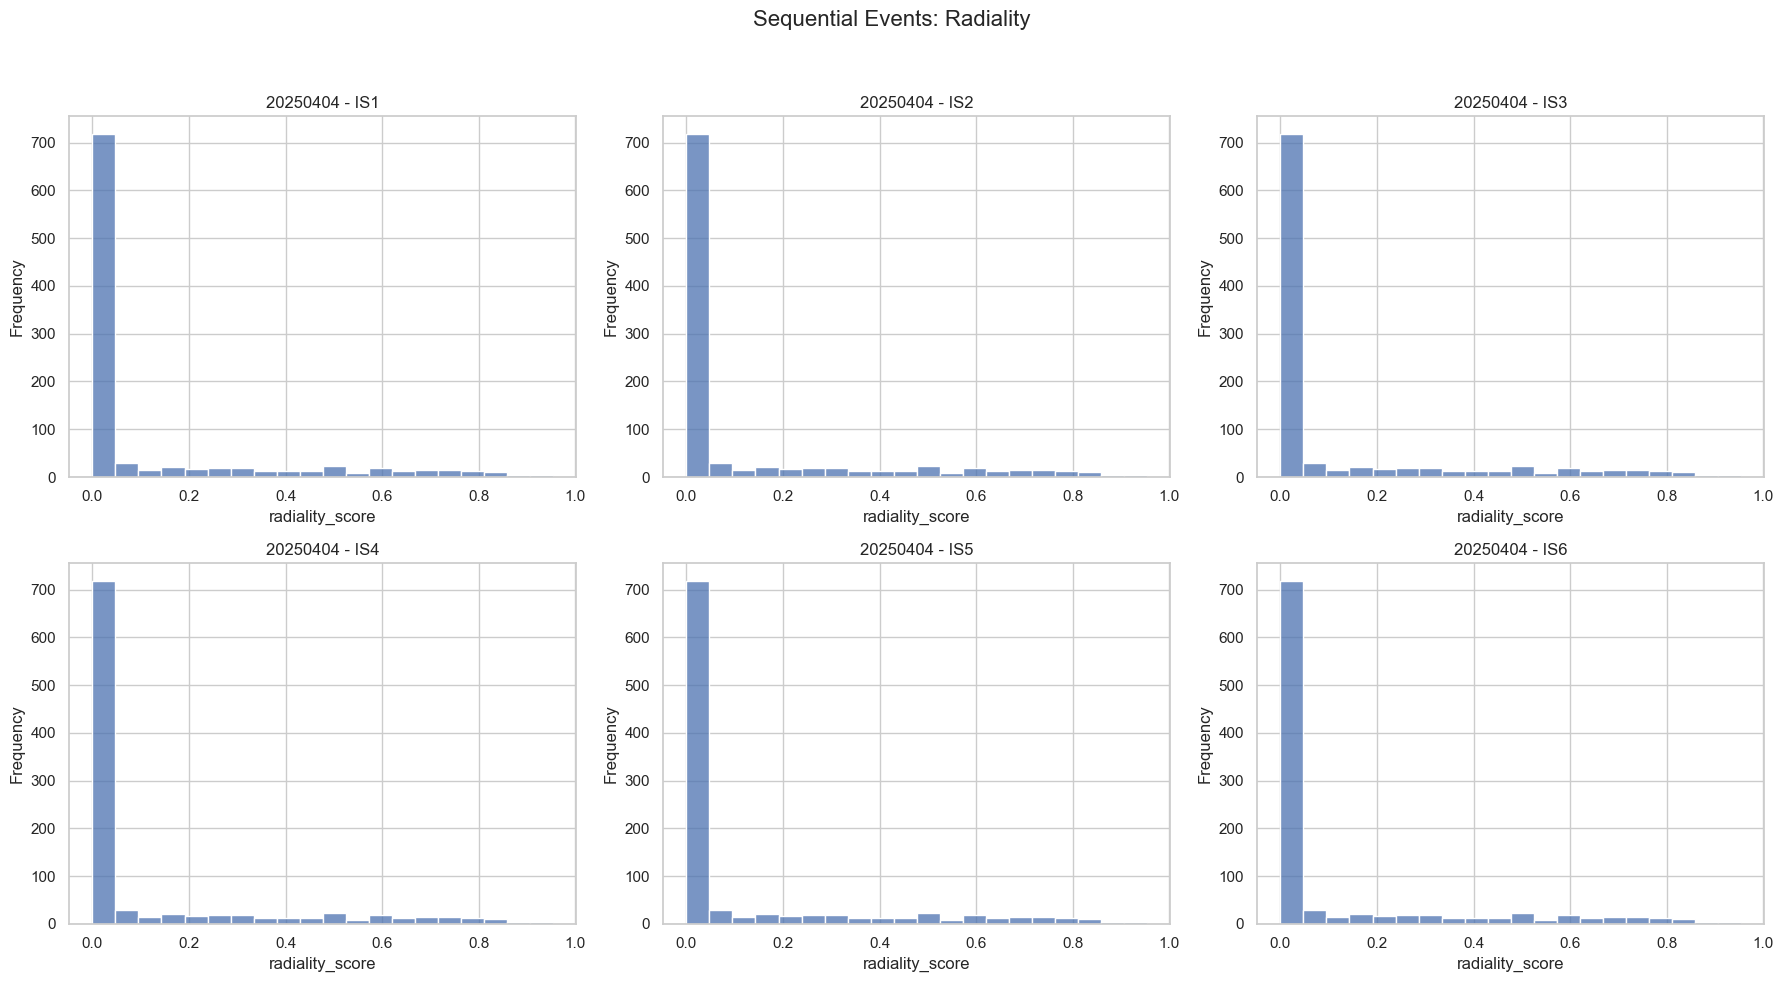

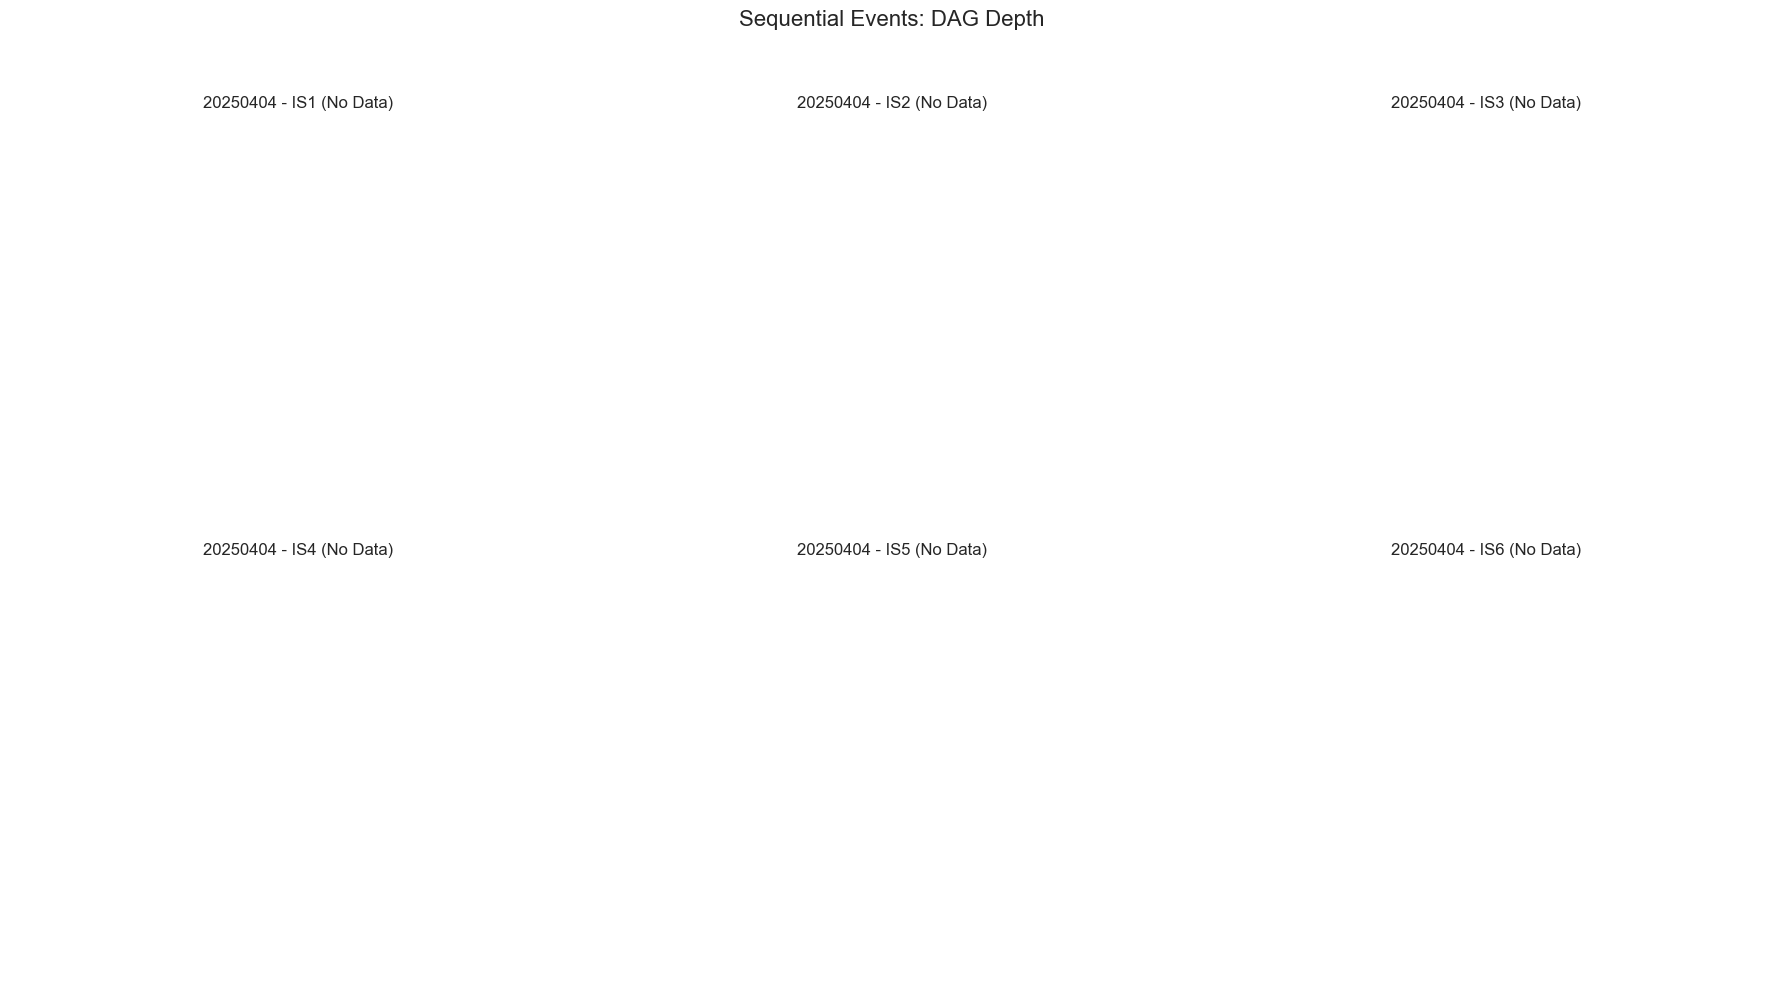

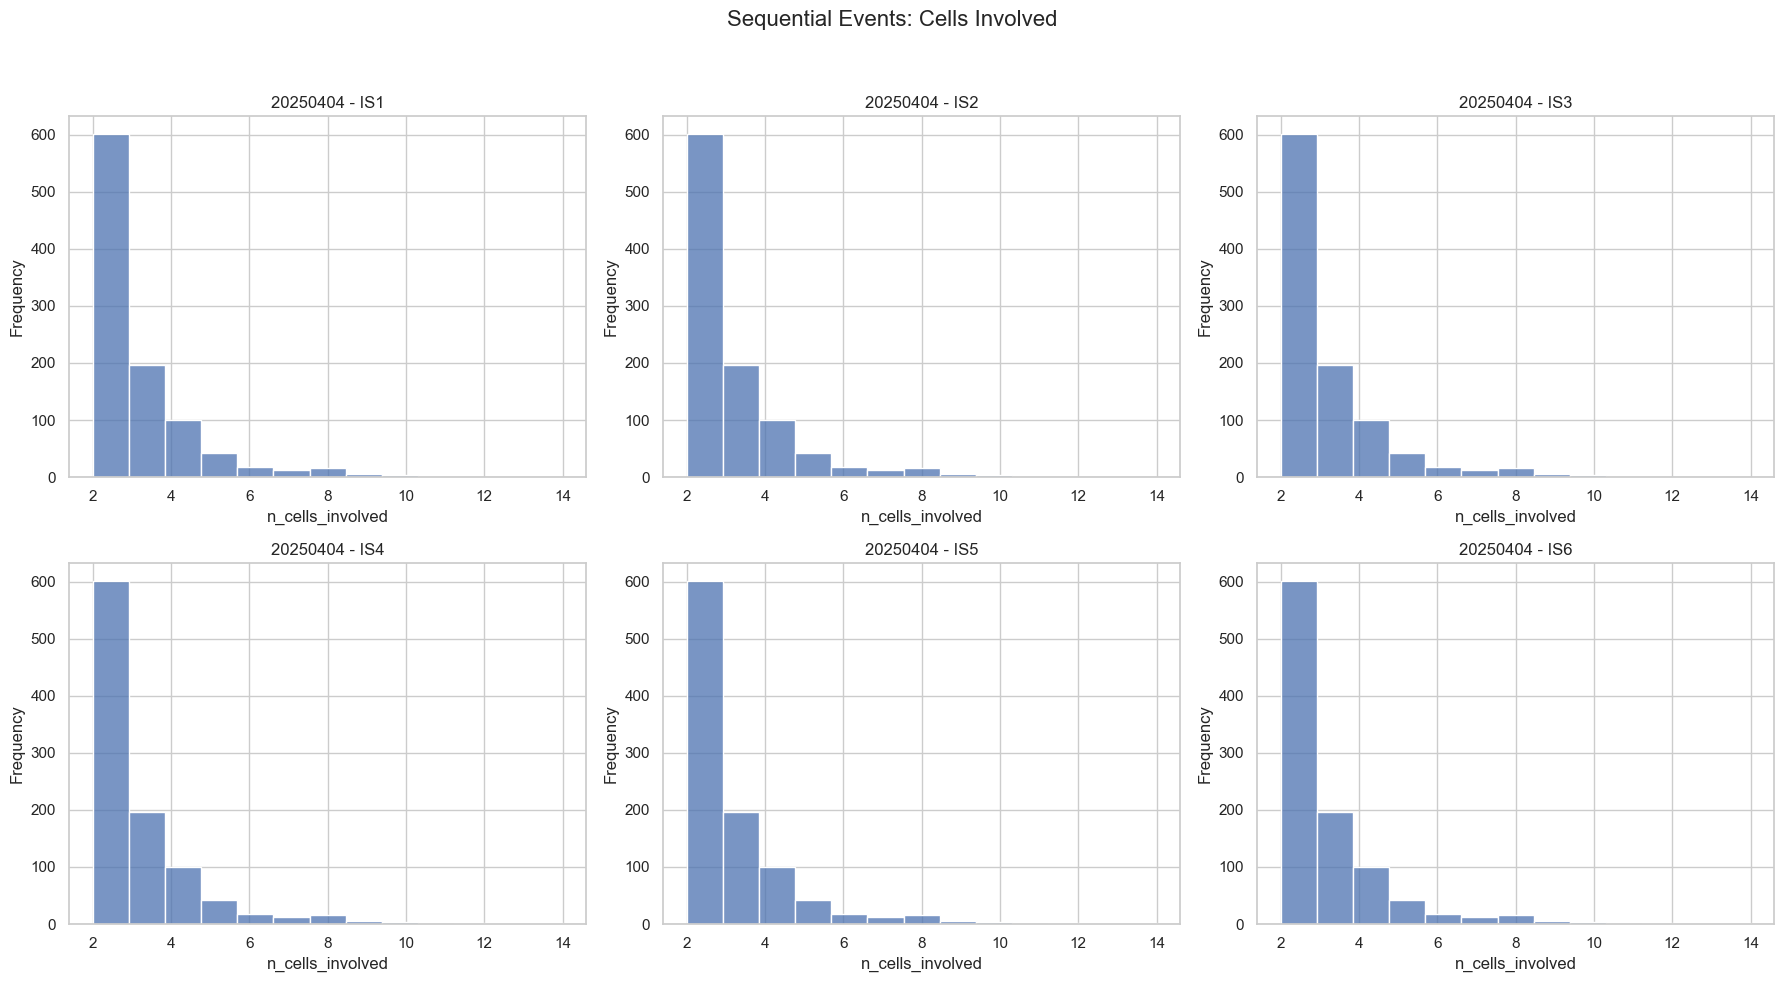

In [9]:
seq_events = events[events["event_type"] == "SequentialEvent"]
plot_metric_by_dataset(seq_events, "communication_time_mean", "Sequential Events: Comm Time", bin_width=1)
plot_metric_by_dataset(seq_events, "communication_speed_mean", "Sequential Events: Comm Speed", bin_count=50)
plot_metric_by_dataset(seq_events, "elongation_score", "Sequential Events: Elongation", bin_count=50)
plot_metric_by_dataset(seq_events, "radiality_score", "Sequential Events: Radiality", bin_width=0.05)
plot_metric_by_dataset(seq_events, "dag_depth", "Sequential Events: DAG Depth", bin_width=1)
plot_metric_by_dataset(seq_events, "n_cells_involved", "Sequential Events: Cells Involved", bin_width=1)

# 🧪 STATISTICAL COMPARISON (KS-Test)

In [11]:

def compare_distributions(df, column, alpha=0.05):
    results = []
    for (a, b) in combinations(df["dataset"].unique(), 2):
        data1 = df[df["dataset"] == a][column].dropna()
        data2 = df[df["dataset"] == b][column].dropna()
        if data1.empty or data2.empty:
            continue
        stat, p = ks_2samp(data1, data2)
        results.append({"metric": column, "A": a, "B": b, "p-value": p, "similar": p > alpha})
    return pd.DataFrame(results)

# Define metrics per table
peak_metrics = ["rel_duration", "prominence", "rel_symmetry_score"]
cell_metrics = ["num_peaks", "periodicity_score"]
event_metrics = ["communication_time_mean", "communication_speed_mean", "elongation_score", "radiality_score", "dag_depth", "n_cells_involved"]

# Compute similarity tables
similarity_results = pd.DataFrame()
for col in peak_metrics:
    similarity_results = pd.concat([similarity_results, compare_distributions(peaks, col)], ignore_index=True)
for col in cell_metrics:
    similarity_results = pd.concat([similarity_results, compare_distributions(cells, col)], ignore_index=True)
for col in event_metrics:
    similarity_results = pd.concat([similarity_results, compare_distributions(seq_events, col)], ignore_index=True)

from IPython.display import display
display(similarity_results)

,metric,A,B,p-value,similar
0,rel_duration,20250404 - IS1,20250404 - IS2,1.0,True
1,rel_duration,20250404 - IS1,20250404 - IS3,1.0,True
2,rel_duration,20250404 - IS1,20250404 - IS4,1.0,True
3,rel_duration,20250404 - IS1,20250404 - IS5,1.0,True
4,rel_duration,20250404 - IS1,20250404 - IS6,1.0,True
...,...,...,...,...,...
145,n_cells_involved,20250404 - IS3,20250404 - IS5,1.0,True
146,n_cells_involved,20250404 - IS3,20250404 - IS6,1.0,True
147,n_cells_involved,20250404 - IS4,20250404 - IS5,1.0,True
148,n_cells_involved,20250404 - IS4,20250404 - IS6,1.0,True
